### Introduction

This project will look to see if there is a relationship between severe weather events and retail alcohol sales in Iowa.

Data:
Severe weather events in the United States (dataset provided by the National Weather Service)
Liquor sales in Iowa (dataset provided by the state of Iowa). 

These datasets are both publicly available on BigQuery and are current as of 08/01/21.

The project will follow this rough order:

* Import the datasets
* Prepare datasets for merging - preliminary exploration
* Merge the datasets
* Prepare to model - deeper exploration
* Model
* Conclusions

Problem definition: If liquor sales in Iowa occur during severe weather, is it possible to predict sales based on the nature of that weather?

Context: 

Climate: Iowa is a state in the Midwestern US. There are 99 continues in Iowa. Iowa has a humid continental climate with extremes of both heat and cold and averages around 50 days of thunderstorm activity per year. The lowest recorded temperature of -44 degrees centigrade and the highest recorded temperature of 48 degrees centigrade reflect the variation in climate. 

Liquor sales: Since the end of the prohibition era the Iowa state government, through the Iowa Alcoholic Beverages Division has regulated and monopolised the wholesale of liquor to retail stores in the state. It is through this system that near complete data on liquor sales is recorded and made available.

TO DO: PUT IN SQL QUERIES
SLICE DATA AND OPERATE ON THIS?
WRITE CONCLUSIONs

### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import string
from datetime import timedelta
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics


%matplotlib inline

# Importing, understanding and cleaning the datasets

About the datasets:

Observations: From the BigQuery console preview, we can see that the time range of the liquor sales dataset is comprised of a single table with time range covered not specified. It is also clear that this dataset contains many redundant columns (e.g. volume sold in litres as well as gallons). 

In contrast, the severe weather events dataset is comprised of seperate tables for every year since 1950. Column names in this dataset are also unclear. Although the dataset concerns a variety of severe weather events it is named "noaa_severe_storms" so we will refer to it as storm data. 

Decisions: We will need to download the liquor sales dataset first, find out the time range to know which of the storm data tables to download.

Note: in preparation to upload the dataset to a Kaggle notebook the liquor sales dataset, being some ~4GB in size was downloaded in pieces from BigQuery and concatenated using cat for the purposes of being zipped for fast upload. As such there are duplicate headers present dataset will need to be read with string formatting which will be faster than specifying datatyes for each column as most will likely be removed anyway.

In [2]:
liquor_file_path =  r"/Users/stu/Desktop/iowa_weather_sales/iowaliquor_data/merged_liquor.csv"

liquor_data = pd.read_csv(liquor_file_path, index_col=False, encoding='iso-8859-1',
                        dtype=str)

In [85]:
liquor_sales =  liquor_data.copy()
# In case we need to re-initialise the dataset from scratch 

liquor_sales.drop(liquor_sales[liquor_sales['date'] == 'date'].index, inplace=True)
# deleting duplicate headers

liquor_sales.shape

(20349538, 24)

We will first convert the date column to datetime to find time range. 

In [86]:
liquor_sales['date'] = pd.to_datetime(liquor_sales['date'], utc = True, errors = 'coerce', format = '%Y-%m-%d')
liquor_sales['date'].dtype

datetime64[ns, UTC]

Next, we will find the date range of the dataset.

In [87]:
print( liquor_sales['date'].min(), liquor_sales['date'].max())

2012-01-03 00:00:00+00:00 2020-12-31 00:00:00+00:00


Now we know to download storm data for 2012 - 2020.

In [88]:
storm_data = pd.read_csv(r"/Users/stu/Desktop/iowa_weather_sales/storms/storms_2012",  index_col=False, encoding='iso-8859-1', dtype=str)

storm_path =  r"/Users/stu/Desktop/iowa_weather_sales/storms/storms_20"

storm_list = []
for i in range(12,21): #looping through path names for succintness
    path = storm_path + str(i)
    data = pd.read_csv(path, index_col=False, encoding='iso-8859-1', dtype=str)
    storm_list.append(data)
    
storm_data = pd.concat(storm_list, axis=0)

In [89]:
storm_copy =  storm_data.copy()
#again, in case we need to re-initialise this dataset.

storm_copy.shape

(535342, 33)

Before filtering the dataset for only records for the state of Iowa, we should check for mislabelled states

In [90]:
unique_states = storm_copy['state'].unique()
print(unique_states)

['Texas' 'Arkansas' 'Missouri' 'Louisiana' 'Georgia' 'Alabama' 'Tennessee'
 'Nevada' 'Oklahoma' 'Illinois' 'Kansas' 'Kentucky' 'Mississippi'
 'Delaware' 'South carolina' 'Indiana' 'Virginia' 'Nebraska' 'Michigan'
 'Florida' 'Pennsylvania' 'South dakota' 'Iowa' 'Hawaii' 'North carolina'
 'North dakota' 'Minnesota' 'Wisconsin' 'New mexico' 'West virginia'
 'Wyoming' 'Maryland' 'Ohio' 'New jersey' 'Colorado' 'Washington' 'Oregon'
 'Massachusetts' 'Idaho' 'New york' 'Montana' 'Arizona' 'Vermont'
 'California' 'Connecticut' 'Maine' 'Puerto rico' 'Utah' 'New hampshire'
 'Rhode island' 'District of columbia' 'Alaska' 'Guam' 'Gulf of mexico'
 'E pacific' 'Hawaii waters' 'Atlantic south' 'Atlantic north'
 'Lake michigan' 'Lake superior' 'Lake erie' 'Lake st clair'
 'Lake ontario' 'Lake huron' 'American samoa' 'Virgin islands'
 'Gulf of alaska' 'St lawrence r']


As there is only one entry for Iowa we can safely select is as follows:

In [91]:
iowa_storms = storm_copy[storm_copy['state'] == 'Iowa']

In [92]:
iowa_storms.shape

(19019, 33)

We can see already that there are far less entries for storms than for liquor sales (20m vs 19k)

### Understanding the datasets

In [93]:
iowa_storms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19019 entries, 854 to 47677
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   episode_id          19019 non-null  object
 1   event_id            19019 non-null  object
 2   state               19019 non-null  object
 3   state_fips_code     19019 non-null  object
 4   event_type          19019 non-null  object
 5   cz_type             19019 non-null  object
 6   cz_fips_code        19019 non-null  object
 7   cz_name             19019 non-null  object
 8   wfo                 19019 non-null  object
 9   event_begin_time    19019 non-null  object
 10  event_timezone      19019 non-null  object
 11  event_end_time      19019 non-null  object
 12  injuries_direct     19019 non-null  object
 13  injuries_indirect   19019 non-null  object
 14  deaths_direct       19019 non-null  object
 15  deaths_indirect     19019 non-null  object
 16  damage_property     

In [94]:
iowa_storms.head()

,episode_id,event_id,state,state_fips_code,event_type,cz_type,cz_fips_code,cz_name,wfo,event_begin_time,...,tor_length,tor_width,tor_other_wfo,location_index,event_range,event_azimuth,reference_location,event_latitude,event_longitude,event_point
854,60799,363235,Iowa,19,hail,C,129,MILLS,OAX,2012-03-26 07:11:00,...,NaN,NaN,NaN,1,2.94,SW,PACIFIC CITY,41.02,-95.86,POINT(-95.86 41.02)
943,60812,363384,Iowa,19,hail,C,29,CASS,DMX,2012-03-29 18:54:00,...,NaN,NaN,NaN,1,2.14,SSE,LEWIS,41.27,-95.07,POINT(-95.07 41.27)
944,60812,363385,Iowa,19,hail,C,29,CASS,DMX,2012-03-29 19:10:00,...,NaN,NaN,NaN,1,2.81,S,GRISWOLD,41.19,-95.14,POINT(-95.14 41.19)
945,60812,363386,Iowa,19,hail,C,153,POLK,DMX,2012-03-29 20:53:00,...,NaN,NaN,NaN,1,0.52,W,ALTOONA,41.65,-93.48,POINT(-93.48 41.65)
950,60838,363537,Iowa,19,hail,C,133,MONONA,OAX,2012-03-30 16:50:00,...,NaN,NaN,NaN,1,1.47,NNE,MAPLETON MUNI ARPT,42.2,-95.79,POINT(-95.79 42.2)


In [95]:
liquor_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20349538 entries, 0 to 20349563
Data columns (total 24 columns):
 #   Column                   Dtype              
---  ------                   -----              
 0   invoice_and_item_number  object             
 1   date                     datetime64[ns, UTC]
 2   store_number             object             
 3   store_name               object             
 4   address                  object             
 5   city                     object             
 6   zip_code                 object             
 7   store_location           object             
 8   county_number            object             
 9   county                   object             
 10  category                 object             
 11  category_name            object             
 12  vendor_number            object             
 13  vendor_name              object             
 14  item_number              object             
 15  item_description         objec

In [96]:
liquor_sales.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S03389400032,2012-01-03 00:00:00+00:00,3521,Ameristar Casino / Council Bluffs,2200 RIVER ROAD,COUNCIL BLUFFS,51501,POINT (-95.909384 41.242291),78,Pottawattamie,...,15626,Jameson,12,750,13.46,20.2,12,242.4,9,2.38
1,S03396400054,2012-01-03 00:00:00+00:00,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,COUNCIL BLUFFS,51501,POINT (-95.8792 41.238092),78,Pottawattamie,...,86190,Hiram Walker Triple Sec,12,1000,2.33,3.49,36,125.64,36,9.51
2,S03371500011,2012-01-03 00:00:00+00:00,4572,Grundy Center Family Foods,"1400, G AVE",GRUNDY CENTER,50638,POINT (-92.782283 42.36157),38,Grundy,...,89196,Jose Cuervo Especial Reposado Tequila,12,750,10.49,15.73,2,31.46,1.5,0.4
3,S03397100038,2012-01-03 00:00:00+00:00,4306,Northside One Stop / Hampton,1208 4TH ST NE,HAMPTON,50441,POINT (-93.202452 42.753045),35,Franklin,...,82787,Dekuyper Buttershots,12,1000,7.35,11.02,3,33.06,3,0.79
4,S03385300045,2012-01-03 00:00:00+00:00,2506,Hy-Vee #1044 / Burlington,3140 AGENCY,BURLINGTON,52601,POINT (-91.136655 40.814666),29,Des Moines,...,76487,Paramount Amaretto,12,1000,4.04,6.06,12,72.72,12,3.17


In [97]:
iowa_storms.head()

,episode_id,event_id,state,state_fips_code,event_type,cz_type,cz_fips_code,cz_name,wfo,event_begin_time,...,tor_length,tor_width,tor_other_wfo,location_index,event_range,event_azimuth,reference_location,event_latitude,event_longitude,event_point
854,60799,363235,Iowa,19,hail,C,129,MILLS,OAX,2012-03-26 07:11:00,...,NaN,NaN,NaN,1,2.94,SW,PACIFIC CITY,41.02,-95.86,POINT(-95.86 41.02)
943,60812,363384,Iowa,19,hail,C,29,CASS,DMX,2012-03-29 18:54:00,...,NaN,NaN,NaN,1,2.14,SSE,LEWIS,41.27,-95.07,POINT(-95.07 41.27)
944,60812,363385,Iowa,19,hail,C,29,CASS,DMX,2012-03-29 19:10:00,...,NaN,NaN,NaN,1,2.81,S,GRISWOLD,41.19,-95.14,POINT(-95.14 41.19)
945,60812,363386,Iowa,19,hail,C,153,POLK,DMX,2012-03-29 20:53:00,...,NaN,NaN,NaN,1,0.52,W,ALTOONA,41.65,-93.48,POINT(-93.48 41.65)
950,60838,363537,Iowa,19,hail,C,133,MONONA,OAX,2012-03-30 16:50:00,...,NaN,NaN,NaN,1,1.47,NNE,MAPLETON MUNI ARPT,42.2,-95.79,POINT(-95.79 42.2)


Observations: There are multiple columns in either dataset containing similar information. As we need to find a way to merge the datasets, it will be very involved to link location of sale and storm on anything other than county (e.g. as opposed to linking on latitude and longitude), so we will retain only county information for this project. Generally severe weather events will not be smaller than counties. Aggregating sales by county will also greatly reduce the size of the liquor sale dataset although it will make it very difficult to work with non-continous variables here - e.g. type of liquor sold as these are hard to aggregate. This is ok because liquor sales is our dependent variable and it will be sufficient to look only at volume and sale and disregard more specific information like type of liquor. 

There are also a lot of null values for some columns in the storm dataset.

Decisions: With reference to the schema detail on the BigQuery console, drop columns referring to location information more granular than counties, store or item specific information. Figure out how to handle missing values. For county name in the storm dataset it appears the cz_name is the best option although according to the schema detail there may be another "z" type of cz_name so we should check if these are still counties.

In [98]:
only_z = iowa_storms[iowa_storms['cz_type']=='Z']
print(list(only_z['cz_name'].unique()))

['SHELBY', 'HARRISON', 'POTTAWATTAMIE', 'MILLS', 'MONTGOMERY', 'FREMONT', 'PAGE', 'MONONA', 'FLOYD', 'ALLAMAKEE', 'CHICKASAW', 'CLAYTON', 'HOWARD', 'MITCHELL', 'FAYETTE', 'WINNESHIEK', 'ADAMS', 'MONROE', 'MARSHALL', 'AUDUBON', 'EMMET', 'APPANOOSE', 'PALO ALTO', 'BOONE', 'BLACK HAWK', 'DECATUR', 'WORTH', 'POLK', 'POWESHIEK', 'RINGGOLD', 'BUTLER', 'BREMER', 'CARROLL', 'WRIGHT', 'GREENE', 'SAC', 'STORY', 'CALHOUN', 'TAMA', 'FRANKLIN', 'TAYLOR', 'CERRO GORDO', 'CASS', 'HAMILTON', 'UNION', 'WAPELLO', 'CRAWFORD', 'CLARKE', 'DAVIS', 'DALLAS', 'GRUNDY', 'WARREN', 'WAYNE', 'WEBSTER', 'WINNEBAGO', 'HANCOCK', 'GUTHRIE', 'HUMBOLDT', 'HARDIN', 'KOSSUTH', 'JASPER', 'MADISON', 'LUCAS', 'POCAHONTAS', 'MARION', 'MAHASKA', 'ADAIR', 'JONES', 'LINN', 'BENTON', 'BUCHANAN', 'CEDAR', 'DELAWARE', 'DUBUQUE', 'IOWA', 'JACKSON', 'JOHNSON', 'VAN BUREN', 'WASHINGTON', 'CLINTON', 'LEE', 'DES MOINES', 'LOUISA', 'HENRY', 'JEFFERSON', 'KEOKUK', 'MUSCATINE', 'SCOTT', "O'BRIEN", 'OSCEOLA', 'PLYMOUTH', 'SIOUX', 'WOODBURY

After confirming that cz_type "Z" cz_names are still counties, we can use cz_name for county name.

In [99]:
iowa_storms.drop(columns = [
    'cz_type', #type of county name
    'episode_id', 
    'state',
    'state_fips_code', #numerical encoding of state
    'cz_fips_code', #numerical encoding of county name
    'wfo', #which weather forecast office generated the report
    'event_timezone',
    'source', #which county level organisation generated the report
    'location_index', #numerical encoding of location
    'event_azimuth', #location of storm from observer
    'reference_location', #for event_azimuth
    'event_latitude', 
    'event_longitude',
    'event_point', #made up of lat and long
    'event_range', #size of the storm
], inplace = True)

In [100]:
liquor_sales.drop(columns=[
    'invoice_and_item_number',
    'store_number',
    'store_name',
    'address',
    'city', 
    'zip_code', 
    'store_location', 
    'county_number',
    'vendor_number', 
    'vendor_name',
    'item_number',
    'volume_sold_gallons',
    'state_bottle_cost', 
    'state_bottle_retail',
    'bottles_sold',
    'bottle_volume_ml',
    'pack',
    'item_description',
    'category_name',
    'category'
    
], inplace=True)

In [101]:
iowa_storms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19019 entries, 854 to 47677
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   event_id           19019 non-null  object
 1   event_type         19019 non-null  object
 2   cz_name            19019 non-null  object
 3   event_begin_time   19019 non-null  object
 4   event_end_time     19019 non-null  object
 5   injuries_direct    19019 non-null  object
 6   injuries_indirect  19019 non-null  object
 7   deaths_direct      19019 non-null  object
 8   deaths_indirect    19019 non-null  object
 9   damage_property    18296 non-null  object
 10  damage_crops       18246 non-null  object
 11  magnitude          8109 non-null   object
 12  magnitude_type     4573 non-null   object
 13  flood_cause        2336 non-null   object
 14  tor_f_scale        516 non-null    object
 15  tor_length         516 non-null    object
 16  tor_width          4063 non-null   obj

In [102]:
liquor_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20349538 entries, 0 to 20349563
Data columns (total 4 columns):
 #   Column              Dtype              
---  ------              -----              
 0   date                datetime64[ns, UTC]
 1   county              object             
 2   sale_dollars        object             
 3   volume_sold_liters  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 776.3+ MB


### Conversion of data to their original datatypes.

In [103]:
print(iowa_storms.iloc[0:1]['event_begin_time']) #get date format

854    2012-03-26 07:11:00
Name: event_begin_time, dtype: object


In [104]:
iowa_storms['event_begin_time'] = pd.to_datetime(iowa_storms['event_begin_time'], utc = True, format = '%Y-%m-%d %H:%M:%S')
iowa_storms['event_end_time'] = pd.to_datetime(iowa_storms['event_end_time'], utc = True, format = '%Y-%m-%d %H:%M:%S')

In [105]:
storms_to_numeric = ['injuries_direct',
                    'injuries_indirect', 
                    'deaths_direct', 
                    'deaths_indirect',
                    'damage_property', 
                    'damage_crops', 
                    'magnitude',
                    'tor_length',
                    'tor_width']

for name in storms_to_numeric:
    iowa_storms[name] = pd.to_numeric(iowa_storms[name]) 
        

liquor_to_numerica = ['sale_dollars','volume_sold_liters']

for name in liquor_to_numerica:
    liquor_sales[name] = pd.to_numeric(liquor_sales[name])
#     print('null after: ', name, len(liquor_sales[pd.isnull(liquor_sales[name])]))

# errors='coerce'

In [106]:
iowa_storms.dtypes

event_id                          object
event_type                        object
cz_name                           object
event_begin_time     datetime64[ns, UTC]
event_end_time       datetime64[ns, UTC]
injuries_direct                    int64
injuries_indirect                  int64
deaths_direct                      int64
deaths_indirect                    int64
damage_property                  float64
damage_crops                     float64
magnitude                        float64
magnitude_type                    object
flood_cause                       object
tor_f_scale                       object
tor_length                       float64
tor_width                        float64
tor_other_wfo                     object
dtype: object

In [107]:
liquor_sales.dtypes

date                  datetime64[ns, UTC]
county                             object
sale_dollars                      float64
volume_sold_liters                float64
dtype: object

### Preparing to merge datasets

We will need to aggregate the liquor sales dataset and ensure as much as possible that county and date columns have consistent format between the datasets.

Obviously the storm dataset has a different kind of time field to the liquor sales dataset. We will approach this by dividing multi-day storms into seperate events.

In [108]:
#check null values in iowa sales county column
print('percent null in county column: ')
print(len(liquor_sales[pd.isnull(liquor_sales['county'])])/len(liquor_sales) * 100)
print('percent null in date column: ')
print(len(liquor_sales[pd.isnull(liquor_sales['date'])])/len(liquor_sales) * 100)

percent null in county column: 
0.7701845614382007
percent null in date column: 
0.0


Neglibible values, we can drop these rows.

In [109]:
liquor_sales = liquor_sales[pd.notnull(liquor_sales['county'])]

punc_table = str.maketrans('', '', string.punctuation)

def clean_string(string):
    string = string.lower().replace(" ","").translate(punc_table)
    #make lowercase, delete whitespace and removed common punctuation
    return string

liquor_sales['county'] = liquor_sales['county'].apply(clean_string)

unique_counties_liquor = liquor_sales['county'].unique()

print(sorted(unique_counties_liquor))

#check for duplicates

['adair', 'adams', 'allamakee', 'appanoose', 'audubon', 'benton', 'blackhawk', 'boone', 'bremer', 'buchanan', 'buenavist', 'buenavista', 'butler', 'calhoun', 'carroll', 'cass', 'cedar', 'cerrogord', 'cerrogordo', 'cherokee', 'chickasaw', 'clarke', 'clay', 'clayton', 'clinton', 'crawford', 'dallas', 'davis', 'decatur', 'delaware', 'desmoines', 'dickinson', 'dubuque', 'elpaso', 'emmet', 'fayette', 'floyd', 'franklin', 'fremont', 'greene', 'grundy', 'guthrie', 'hamilton', 'hancock', 'hardin', 'harrison', 'henry', 'howard', 'humboldt', 'ida', 'iowa', 'jackson', 'jasper', 'jefferson', 'johnson', 'jones', 'keokuk', 'kossuth', 'lee', 'linn', 'louisa', 'lucas', 'lyon', 'madison', 'mahaska', 'marion', 'marshall', 'mills', 'mitchell', 'monona', 'monroe', 'montgomery', 'muscatine', 'obrien', 'osceola', 'page', 'paloalto', 'plymouth', 'pocahontas', 'polk', 'pottawatta', 'pottawattamie', 'poweshiek', 'ringgold', 'sac', 'scott', 'shelby', 'sioux', 'story', 'tama', 'taylor', 'union', 'vanburen', 'wap

We can see two duplicates and can manually correct these before aggregating.

In [110]:
liquor_sales.loc[liquor_sales['county'] == 'buenavist', 'county'] = 'buenavista'
liquor_sales.loc[liquor_sales['county'] == 'cerrogord', 'county'] = 'cerrogordo'

aggregated = liquor_sales.groupby(['county','date']).agg({'sale_dollars': np.sum, 'volume_sold_liters':np.sum})
aggregated_sales = aggregated.reset_index()

iowa_storms['cz_name'] = iowa_storms['cz_name'].apply(clean_string)

unique_counties_storms = iowa_storms['cz_name'].unique()
print(sorted(unique_counties_storms))

#check for duplicates

['adair', 'adams', 'allamakee', 'appanoose', 'audubon', 'benton', 'blackhawk', 'boone', 'bremer', 'buchanan', 'buenavista', 'butler', 'calhoun', 'carroll', 'cass', 'cedar', 'cerrogordo', 'cherokee', 'chickasaw', 'clarke', 'clay', 'clayton', 'clinton', 'crawford', 'dallas', 'davis', 'decatur', 'delaware', 'desmoines', 'dickinson', 'dubuque', 'emmet', 'fayette', 'floyd', 'franklin', 'fremont', 'greene', 'grundy', 'guthrie', 'hamilton', 'hancock', 'hardin', 'harrison', 'henry', 'howard', 'humboldt', 'ida', 'iowa', 'jackson', 'jasper', 'jefferson', 'johnson', 'jones', 'keokuk', 'kossuth', 'lee', 'linn', 'louisa', 'lucas', 'lyon', 'madison', 'mahaska', 'marion', 'marshall', 'mills', 'mitchell', 'monona', 'monroe', 'montgomery', 'muscatine', 'obrien', 'osceola', 'page', 'paloalto', 'plymouth', 'pocahontas', 'polk', 'pottawattamie', 'poweshiek', 'ringgold', 'sac', 'scott', 'shelby', 'sioux', 'story', 'tama', 'taylor', 'union', 'vanburen', 'wapello', 'warren', 'washington', 'wayne', 'webster',

Now look for matchup between datasets

In [111]:
print('counties in liquor data, not in storm set')
for county in unique_counties_liquor: #(liquor counties)
    if county not in unique_counties_storms: #longer than liquor_counties
        print(county)
        

counties in liquor data, not in storm set
pottawatta
cerrogord
buenavist
elpaso


In [112]:
print('counties in storm data, not in liquor set')
for county in unique_counties_storms: #(liquor counties)
    if county not in unique_counties_liquor: #longer than liquor_counties
        print(county)

counties in storm data, not in liquor set


At least most counties are present. Now for editing the time feature of the storms dataset.

In [113]:
#change event times to day only, inline with date on liquor sales

iowa_storms['event_begin_time'] = iowa_storms['event_begin_time'].apply(lambda x:x.date())
iowa_storms['event_end_time'] = iowa_storms['event_end_time'].apply(lambda x:x.date())

iowa_storms['days_duration'] = iowa_storms['event_end_time'] -iowa_storms['event_begin_time'] #timedelta, event_begin - event_end
iowa_storms['date'] = iowa_storms['event_begin_time'] 

iowa_storms['days_duration'] = iowa_storms['days_duration'].apply(lambda x:x.days)

max_duration = max(iowa_storms['days_duration'])

iowa_seperate_storms = []

for i in range(max_duration):
    temp_df = iowa_storms[iowa_storms['days_duration'] > i]
    temp_df['date'] = temp_df['date'].apply(lambda x: x+timedelta(days=(i+1)))
    iowa_seperate_storms.append(temp_df)

iowa_storms = pd.concat(iowa_seperate_storms, axis=0)

iowa_storms.shape

(29944, 20)

Now there is a seperate row for each day of a storm we can drop event_begin_time and event_end_time as well as event_id.

In [114]:
iowa_storms.drop(columns=['event_begin_time', 'event_end_time','event_id'], axis=1, inplace=True)
iowa_storms = iowa_storms.rename(columns={'cz_name':'county'})

Lastly, make sure they are in the same format.

In [115]:
iowa_storms['date'] = iowa_storms['date'] = pd.to_datetime(iowa_storms['date'], utc = True, errors = 'coerce', format = '%Y-%m-%d')

In [116]:
# aggregated_sales['date'] = aggregated_sales['date'].apply(lambda x : x.date)

In [117]:
# storms_effect = aggregated_sales.merge(iowa_storms,how='left', on = ['date','county'])

In [118]:
storms_vs_sales = aggregated_sales.merge(iowa_storms, how = 'inner', on = ['date','county'])
storms_vs_sales.shape

(7301, 19)

### Cleaning and deeper exploration

In [119]:
column_names = list(storms_vs_sales.columns.values)

for name in column_names:
    null = storms_vs_sales[pd.isnull(storms_vs_sales[name])]
    print('percent null in ', name, ':', math.floor(len(null)/len(storms_vs_sales) *100))

percent null in  county : 0
percent null in  date : 0
percent null in  sale_dollars : 0
percent null in  volume_sold_liters : 0
percent null in  event_type : 0
percent null in  injuries_direct : 0
percent null in  injuries_indirect : 0
percent null in  deaths_direct : 0
percent null in  deaths_indirect : 0
percent null in  damage_property : 7
percent null in  damage_crops : 15
percent null in  magnitude : 99
percent null in  magnitude_type : 99
percent null in  flood_cause : 77
percent null in  tor_f_scale : 100
percent null in  tor_length : 100
percent null in  tor_width : 77
percent null in  tor_other_wfo : 100
percent null in  days_duration : 0


Observations: we already see some extremely high values for magnitude and tornado related columns. Referring to the schema detail we can see that magnitude largely refers to high winds. Obviously tornados relate to events with high winds. We can surmise that there were in fact no recorded sales during tornados, possibly because the shops shut down. 

In [120]:
storms_vs_sales['event_type'].value_counts()

drought                    4338
flood                      1602
heavy rain                  522
winter storm                245
extreme cold/wind chill     143
winter weather              114
excessive heat              106
flash flood                  49
heat                         46
heavy snow                   46
blizzard                     39
high wind                    17
cold/wind chill              16
dense fog                     8
ice storm                     7
frost/freeze                  3
Name: event_type, dtype: int64

We can confirm that tornados have disappeared from the event_type list. We can delete tornado and magnitude related columns.

In [121]:
storms_vs_sales.drop(columns = [
    'tor_f_scale', 
    'tor_length',
    'tor_length',
    'tor_width',
    'tor_other_wfo',
    'magnitude',
    'magnitude_type'
], inplace = True)

We have no way of imputing missing values for damage to property and damage to crops so we will drop these rows.

In [122]:
storms_vs_sales = storms_vs_sales[pd.notnull(storms_vs_sales['damage_property'])]
storms_vs_sales = storms_vs_sales[pd.notnull(storms_vs_sales['damage_crops'])]

Looking at flood_cause, we can look to possibly create new event_types that embody this information, useful as flood is the second highest event type.

In [123]:
storms_vs_sales['flood_cause'].value_counts()

Heavy Rain                1208
Heavy Rain / Snow Melt     418
Planned Dam Release         15
Ice Jam                      9
Dam / Levee Break            1
Name: flood_cause, dtype: int64

In [124]:
print(len(storms_vs_sales[pd.isnull(storms_vs_sales['flood_cause'])]))
print(storms_vs_sales['flood_cause'].unique())

4404
[nan 'Heavy Rain' 'Heavy Rain / Snow Melt' 'Ice Jam' 'Dam / Levee Break'
 'Planned Dam Release']


In [125]:
flood_causes = ['Heavy Rain',
                'Heavy Rain / Snow Melt',
                'Planned Dam Release',
                'Ice Jam','Dam / Levee Break']

flood_encode = {'Heavy Rain': 'rain flood',
                'Heavy Rain / Snow Melt':'snow flood',
               'Planned Dam Release':'other flood',
                'Ice Jam' : 'other flood',
                'Dam / Levee Break' : 'other flood'
               }

for cause in flood_causes:
    mask = storms_vs_sales['flood_cause'] == cause
    storms_vs_sales.loc[mask, 'event_type'] = flood_encode[cause]

storms_vs_sales.drop(columns = [
    'flood_cause'
], inplace = True)

In [126]:
storms_vs_sales['event_type'].value_counts()

drought                    3116
rain flood                 1208
heavy rain                  522
snow flood                  418
winter storm                235
extreme cold/wind chill     143
winter weather              109
excessive heat              106
heat                         46
heavy snow                   44
blizzard                     39
other flood                  25
cold/wind chill              14
high wind                    12
dense fog                     8
ice storm                     7
frost/freeze                  3
Name: event_type, dtype: int64

In [127]:
storms_vs_sales.drop(columns = [
    'county',
    'date'
], inplace = True)

Sanity checking for outliers.

In [128]:
col_names = storms_vs_sales.columns

for name in col_names:
    print('percent zero in', name, ': ', len(storms_vs_sales[storms_vs_sales[name]==0])/len(storms_vs_sales) *100)


percent zero in sale_dollars :  0.41288191577208916
percent zero in volume_sold_liters :  0.0
percent zero in event_type :  0.0
percent zero in injuries_direct :  99.93393889347647
percent zero in injuries_indirect :  99.98348472336912
percent zero in deaths_direct :  99.9009083402147
percent zero in deaths_indirect :  100.0
percent zero in damage_property :  91.70933113129645
percent zero in damage_crops :  78.53014037985136
percent zero in days_duration :  0.0


There is extremely low variance in injuries and deaths columns. We should keep track of this.

# Modeling 

At this point, we have both categorical and continous dependent variables and two independent variables. There are a number of potential models we can try to fit to the data. 

We will firstly test for assumptions of these models and then test suitable models for predictive power.

In [129]:
storms_vs_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6055 entries, 0 to 7300
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sale_dollars        6055 non-null   float64
 1   volume_sold_liters  6055 non-null   float64
 2   event_type          6055 non-null   object 
 3   injuries_direct     6055 non-null   int64  
 4   injuries_indirect   6055 non-null   int64  
 5   deaths_direct       6055 non-null   int64  
 6   deaths_indirect     6055 non-null   int64  
 7   damage_property     6055 non-null   float64
 8   damage_crops        6055 non-null   float64
 9   days_duration       6055 non-null   int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 520.4+ KB


<AxesSubplot:>

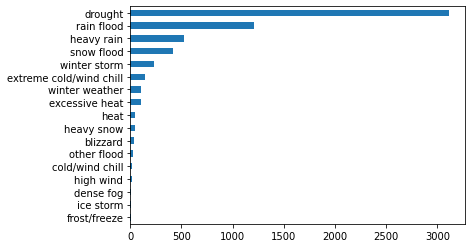

In [130]:
storms_vs_sales['event_type'].value_counts().sort_values().plot(kind = 'barh')


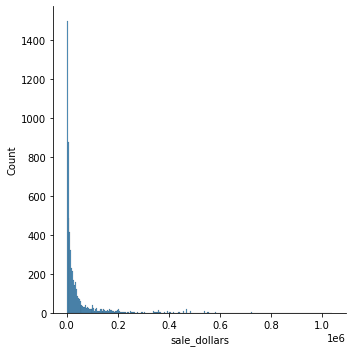

In [131]:
sns.displot(storms_vs_sales['sale_dollars'])

We can attempt to normalize this distribution via a log transformation.

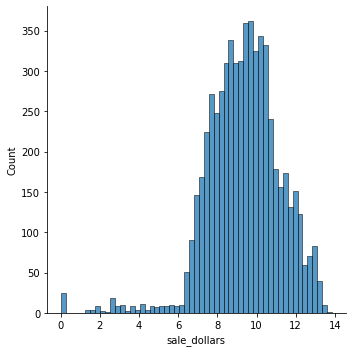

In [132]:
mask = storms_vs_sales['sale_dollars'] == 0
storms_vs_sales.loc[mask, 'sale_dollars'] = 1

sns.displot(np.log(storms_vs_sales['sale_dollars']))

In [133]:
# storms_vs_sales['sale_dollars'] = storms_vs_sales['sale_dollars'].apply(lambda x : np.log(x))
# storms_vs_sales['sale_dollars'] = storms_vs_sales['sale_dollars'].apply(lambda x : x * x)

This seems to be effective in approximating a normal distribution. 

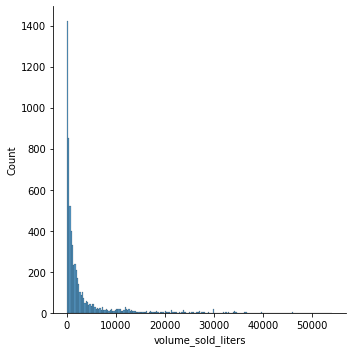

In [134]:
sns.displot(storms_vs_sales['volume_sold_liters'])

Similarly we could apply a log transformation.

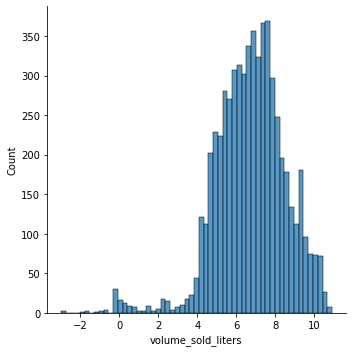

In [135]:
mask = storms_vs_sales['volume_sold_liters'] == 0
storms_vs_sales.loc[mask, 'volume_sold_liters'] = 1

sns.displot(np.log(storms_vs_sales['volume_sold_liters']))

Also looking good.

In [136]:
# storms_vs_sales['volume_sold_liters'] = storms_vs_sales['volume_sold_liters'].apply(lambda x : np.log(x))
# storms_vs_sales['volume_sold_liters'] = storms_vs_sales['volume_sold_liters'].apply(lambda x : x * x)

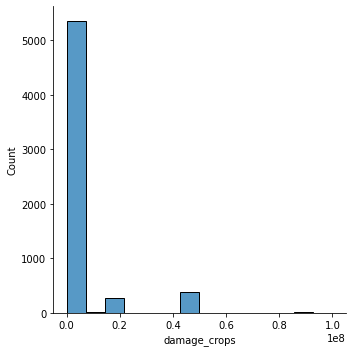

In [137]:
sns.displot(storms_vs_sales['damage_crops'])

# no_zero = storms_vs_sales.copy()

# no_zero[no_zero['damage_crops']==0] = 1
# sns.displot(np.log(no_zero['damage_crops']))

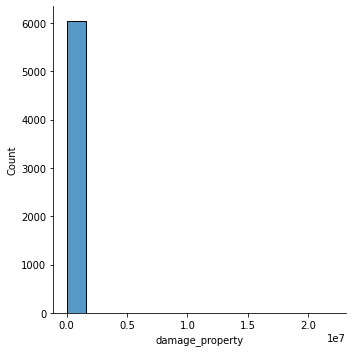

In [138]:
sns.displot(storms_vs_sales['damage_property'])

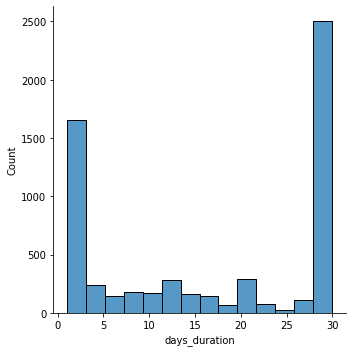

In [139]:
sns.displot(storms_vs_sales['days_duration'])

<AxesSubplot:xlabel='volume_sold_liters', ylabel='damage_crops'>

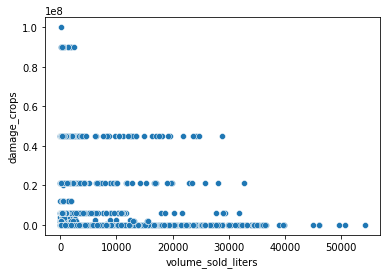

In [140]:
sns.scatterplot(data=storms_vs_sales, x="volume_sold_liters", y="damage_crops")

<AxesSubplot:xlabel='volume_sold_liters', ylabel='damage_property'>

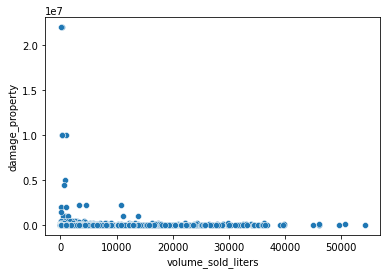

In [141]:
sns.scatterplot(data=storms_vs_sales, x="volume_sold_liters", y="damage_property")

<AxesSubplot:xlabel='volume_sold_liters', ylabel='days_duration'>

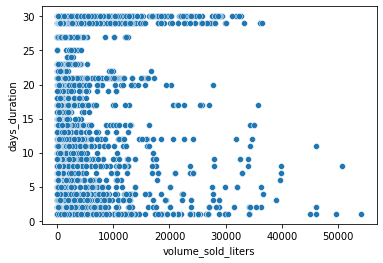

In [142]:
sns.scatterplot(data=storms_vs_sales, x="volume_sold_liters", y="days_duration")

<AxesSubplot:xlabel='sale_dollars', ylabel='damage_crops'>

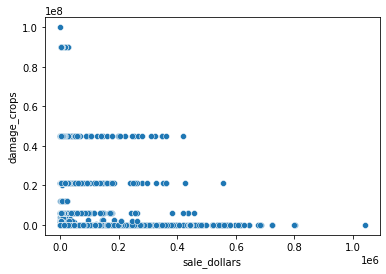

In [143]:
sns.scatterplot(data=storms_vs_sales, x="sale_dollars", y="damage_crops")

<AxesSubplot:xlabel='sale_dollars', ylabel='damage_property'>

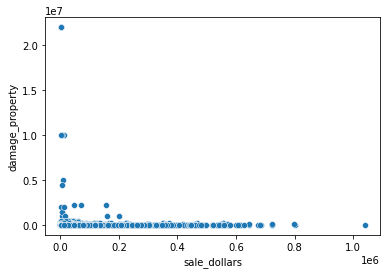

In [144]:
sns.scatterplot(data=storms_vs_sales, x="sale_dollars", y="damage_property")

<AxesSubplot:xlabel='sale_dollars', ylabel='days_duration'>

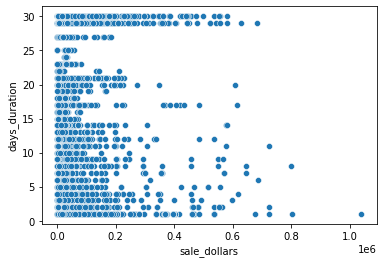

In [145]:
sns.scatterplot(data=storms_vs_sales, x="sale_dollars", y="days_duration")

None of the continuous variables have a clear linear or simple polynomial relationship to sale_dollars or volume_sold. Because of this we can try using a Random Forest approach to modelling this data... possibly a neural network. With no formal distributional assumptions we can also avoid having to normalise our dependent variables via log transformations. It can also handle our combination of continous and categorial data although we may want to manually bin continous data later.

In [146]:
unique_events = storms_vs_sales['event_type'].unique()

for event in unique_events:
    storms_vs_sales[event] = storms_vs_sales['event_type'] == event
    storms_vs_sales[event] = storms_vs_sales[event].apply(lambda x: x*1)
    


In [147]:
storms_vs_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6055 entries, 0 to 7300
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sale_dollars             6055 non-null   float64
 1   volume_sold_liters       6055 non-null   float64
 2   event_type               6055 non-null   object 
 3   injuries_direct          6055 non-null   int64  
 4   injuries_indirect        6055 non-null   int64  
 5   deaths_direct            6055 non-null   int64  
 6   deaths_indirect          6055 non-null   int64  
 7   damage_property          6055 non-null   float64
 8   damage_crops             6055 non-null   float64
 9   days_duration            6055 non-null   int64  
 10  drought                  6055 non-null   int64  
 11  extreme cold/wind chill  6055 non-null   int64  
 12  heavy rain               6055 non-null   int64  
 13  excessive heat           6055 non-null   int64  
 14  winter storm            

In [148]:
storms_vs_sales.drop(columns = [
    'event_type'
], inplace = True)

In [149]:
storms_vs_sales.shape

(6055, 26)

### Modelling

In [150]:
print(storms_vs_sales.columns)

Index(['sale_dollars', 'volume_sold_liters', 'injuries_direct',
       'injuries_indirect', 'deaths_direct', 'deaths_indirect',
       'damage_property', 'damage_crops', 'days_duration', 'drought',
       'extreme cold/wind chill', 'heavy rain', 'excessive heat',
       'winter storm', 'rain flood', 'heavy snow', 'heat', 'snow flood',
       'frost/freeze', 'dense fog', 'blizzard', 'winter weather', 'ice storm',
       'other flood', 'high wind', 'cold/wind chill'],
      dtype='object')


In [151]:
X = storms_vs_sales[['damage_property',
                     'injuries_direct',
                     'injuries_indirect',
                     'deaths_direct',
                     'deaths_indirect',
                     'damage_crops',
                     'days_duration', 
                     'drought', 
                     'extreme cold/wind chill', 
                     'heavy rain',
                     'excessive heat', 
                     'winter storm', 
                     'heavy snow', 
                     'heat',
                     'frost/freeze', 
                     'dense fog', 
                     'blizzard',
                     'winter weather', 
                     'ice storm', 
                     'high wind', 
                     'cold/wind chill']]

y_dollars = storms_vs_sales['sale_dollars']

y_vol = storms_vs_sales['volume_sold_liters']


X_train_dollars, X_test_dollars, y_train_dollars, y_test_dollars = train_test_split(X, y_dollars, test_size=0.2, random_state=0)

X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(X, y_vol, test_size=0.2, random_state=0)

In [152]:
sc = StandardScaler()
X_train_dollars = sc.fit_transform(X_train_dollars)
X_test_dollars = sc.transform(X_test_dollars)

X_train_vol = sc.fit_transform(X_train_vol)
X_test_vol = sc.transform(X_test_vol)

In [153]:
# storms_vs_sales = storms_vs_sales.drop(storms_vs_sales[storms_vs_sales == np.inf].index)

In [154]:
regressor_dollars = RandomForestRegressor(n_estimators=200, random_state=0)
regressor_vol = RandomForestRegressor(n_estimators=200, random_state=0)


regressor_dollars.fit(X_train_dollars, y_train_dollars)
y_pred_dollars = regressor_dollars.predict(X_test_dollars)

regressor_vol.fit(X_train_vol, y_train_vol)
y_pred_vol = regressor_vol.predict(X_test_vol)

For comparing to other models

In [155]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_dollars, y_pred_dollars))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_dollars, y_pred_dollars))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_dollars, y_pred_dollars)))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test_dollars, y_pred_dollars))



Mean Absolute Error: 48289.60225880386
Mean Squared Error: 8005531328.205634
Root Mean Squared Error: 89473.63482169277
Mean Absolute Percentage Error: 141.89739813435708


In [156]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_vol, y_pred_vol))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_vol, y_pred_vol))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_vol, y_pred_vol)))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test_vol, y_pred_vol))



Mean Absolute Error: 3127.6756105332324
Mean Squared Error: 31234890.917748153
Root Mean Squared Error: 5588.818382963267
Mean Absolute Percentage Error: 41.006516112499426


r2, evs

In [164]:
print('R2:', metrics.r2_score(y_test_vol, y_pred_vol))
print('evs:', metrics.explained_variance_score(y_test_vol, y_pred_vol))




R2: 0.07364965363258569
evs: 0.07366565820165061


Not looking promising. TODO: look for a better method of connecting datasets. At the moment this one doesn't take into account a potential delay between consumer purchases or lack of during severe weather and the resupply/purchase by the liquor stores... 

can try also running another model to compare MSE.